# CSCG for counterfactual causal reasoning through episodic memories
With two conditions, one that is causally related to coming to late to the airport, and one  that is not.

**Clone the repo from github, Install the necessary libraries**

In [1]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph

***Import the needed python modules***

In [ ]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room, forwardE_mp, backtraceE, backtrace, forward_mp, rargmax, forwardE, backtraceE
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import tools

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

np.random.seed(52)

transition_matrix = np.array([   # lines transitions from columns transitions to...
    [0.0, 0.6, 0.0, 0.4, 0.0, 0.0],   # 0, Station to Toilet, Lunch or Train1
    [0.0, 0.0, 0.3, 0.5, 0.0, 0.2],   # 1, Toilet to Train1 or Train2
    [0.0, 0.0, 0.0, 0.2, 0.0, 0.8],   # 2, Lunch to Train1 or Train2
    [0.1, 0.0, 0.0, 0.0, 0.9, 0.0],   # 3, Train1 to Station or Airport
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],   # 4, Aiport to Station
    [0.9, 0.0, 0.0, 0.0, 0.1, 0.0],   # 5, Train2 to Station or Airport
])

seq_length = 10000
seq_state_t0 = 0
pseudocount = 1e-4

n_clones = np.array(
    [1, 1, 1, 2, 1], # define number of clones per state
    dtype = np.int64)

n_iter = 500

#### Generate sequence

In [3]:
seq = tools.generate_markov_seq(transition_matrix, seq_state_t0, seq_length)

# We want the algorithm to figure out the different train contexts by itself, thus we give them the same identity.
seq[seq == 5] = 3

# we create dummy action
a = np.zeros(seq_length, dtype=np.int64)

#### Train CSCG

In [4]:
# Generate data and train a CSCG.
chmm = CHMM(
    n_clones=n_clones,
    pseudocount=pseudocount,
    x=seq, a=a,
    seed=44)

progression = chmm.learn_em_T(seq, a, n_iter=n_iter)



Average number of clones: 1.2


  4%|▎         | 18/500 [00:03<01:43,  4.65it/s, train_bps=0.64]


#### Apply Viterbi pruning

In [5]:
chmm.learn_viterbi_T(seq, a, n_iter=100)

  2%|▏         | 2/100 [00:00<00:44,  2.22it/s, train_bps=0.65]


[np.float32(0.6796574), np.float32(0.65004), np.float32(0.65004)]

In [6]:
seq[:20], np.shape(chmm.T[0])

(array([0, 3, 0, 1, 3, 0, 3, 0, 3, 4, 0, 3, 4, 0, 1, 3, 4, 0, 3, 4]), (6, 6))

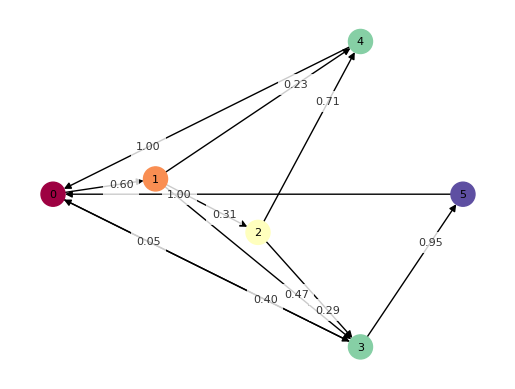

In [7]:
pos = [
    [0, 0.,],
    [1, .01,],
    [2, -.025,],
    [3, -.1],
    [3, .1],
    [4, 0.,],
]


kwargs_nxdraw = {
    'node_size': 300,
    'font_size': 8,
    'arrows': True,
#    'connectionstyle': 'arc,rad=0.4'
}

kwargs_fig = {
    'figsize': [4, 4],
}

kwargs_nxdrawedgelabel = {
    'font_size': 8,
    'label_pos': 0.7,  # Position along edge (0=start, 1=end)
    'bbox': dict(alpha=0.8, facecolor="white", edgecolor="none"),
    'rotate': False,
    'font_color': "#333333",
}

fig, ax = tools.plot_graph(
    chmm, seq, a, output_file="figures/test.pdf",
    pos=pos,
    label_nodes=False,
    kwargs_fig=kwargs_fig,
    kwargs_nxdraw=kwargs_nxdraw,
    kwargs_nxdrawedgelabel=kwargs_nxdrawedgelabel,
)


In [8]:
#note have another scenario that does not fulfil the criteria

In [ ]:
events = {
    "start": 0, 
    "toilet": 1, 
    "lunch": 2, 
    "train_ontime": 3,
    "train_late": 4, 
    "airport": 5
}


# e means miss the plane
# c means going to toilet


# validate theorem i)
# P(e_given_c) > P(not_e_given_c)

e_given_c = (chmm.T[0, 1, 2] * (chmm.T[0, 2, 3] * chmm.T[0, 3, 0] + chmm.T[0, 2, 4] * chmm.T[0, 4, 0]) + 
               chmm.T[0, 1, 3]*chmm.T[0, 3, 0]+chmm.T[0, 1, 4]*chmm.T[0, 4, 0])

not_e_given_c = (chmm.T[0, 1, 2] * (chmm.T[0, 2, 3] * chmm.T[0, 3, 5] + chmm.T[0, 2, 4] * chmm.T[0, 4, 5]) + 
               chmm.T[0, 1, 3]*chmm.T[0, 3, 5]+chmm.T[0, 1, 4]*chmm.T[0, 4, 5])



print("e_given_c", e_given_c)
print("not_e_given_c", not_e_given_c)
print( "P(e_given_c) > P(not_e_given_c)", (e_given_c) > (not_e_given_c))


# validate theorem ii)
# P(not_e_given_not_c) > P(e_given_not_c)

not_e_given_not_c = (chmm.T[0, 0, 3] * chmm.T[0, 3, 5] +
                    chmm.T[0, 0, 4] * chmm.T[0, 4, 5])

e_given_not_c = (chmm.T[0, 0, 3] * chmm.T[0, 3, 0] +
                    chmm.T[0, 0, 4] * chmm.T[0, 4, 0])


print("not_e_given_not_c", not_e_given_not_c)
print("e_given_not_c", e_given_not_c)
print("P(not_e_given_not_c) > P(e_given_not_c)", (not_e_given_not_c) > (e_given_not_c))

## toilet is not a cause for missing the plane


#c1 = lunch 
# validate theorem i) 
# P(e_given_c1) > P(not_e_given_c1)


e_given_c1 =  (chmm.T[0, 2, 3] * chmm.T[0, 3, 0] + 
     chmm.T[0, 2, 4] * chmm.T[0, 4, 0])

not_e_given_c1 = (chmm.T[0, 2, 3] * chmm.T[0, 3, 5] + 
     chmm.T[0, 2, 4] * chmm.T[0, 4, 5])

print("e_given_c1 =", e_given_c1)
print("not_e_given_c1", not_e_given_c1)

print("P(e_given_c1) > P(not_e_given_c1)", (e_given_c1) > (not_e_given_c1))


# validate theorem ii)
# P(not_e_given_not_c1) > P(e_given_not_c1)
not_e_given_not_c1 = (chmm.T[0, 0, 1]*(chmm.T[0, 1, 3] * chmm.T[0, 3, 5] +
                    chmm.T[0, 1, 4] * chmm.T[0, 4, 5]) + 
                    (chmm.T[0, 0, 3] * chmm.T[0, 3, 5] +
                    chmm.T[0, 0, 4] * chmm.T[0, 4, 5]))

e_given_not_c1 = (chmm.T[0, 0, 1]*(chmm.T[0, 1, 3] * chmm.T[0, 3, 0] +
                    chmm.T[0, 1, 4] * chmm.T[0, 4, 0]) + 
                    (chmm.T[0, 0, 3] * chmm.T[0, 3, 0] +
                    chmm.T[0, 0, 4] * chmm.T[0, 4, 0]))


print("e_given_not_c1", e_given_not_c1)
print("not_e_given_not_c1", not_e_given_not_c1)
print("P(not_e_given_not_c1) > P(e_given_not_c1)", (not_e_given_not_c1) > (e_given_not_c1))

## Lunch is a cause for missing the plane

e_given_c 0.4737097
not_e_given_c 0.5262894
P(e_given_c) > P(not_e_given_c) False
not_e_given_not_c 0.3832311
e_given_not_c 0.021216339
P(not_e_given_not_c) > P(e_given_not_c) True
e_given_c1 = 0.72152257
not_e_given_c1 0.27847612
P(e_given_c1) > P(not_e_given_c1) True
e_given_not_c1 0.17196706
not_e_given_not_c1 0.64596164
P(not_e_given_not_c1) > P(e_given_not_c1) True


In [ ]:
#look at winner graph for different scenarios (i.e, max probs between paths)

(1, 6, 6)

In [ ]:
#try to use NetworkX

import networkx as nx

G = nx.DiGraph()

T = chmm.T[0]  # Extract transition matrix

# Add edges with weights (probabilities)
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        if T[i, j] > 0:
            G.add_edge(i, j, weight=T[i, j])

In [26]:
# List all nodes
print("Nodes:", list(G.nodes))

# List all edges with weights
print("Edges:")
for u, v, d in G.edges(data=True):
    print(f"{u} -> {v}, weight = {d['weight']:.2f}")

Nodes: [0, 1, 2, 3, 4, 5]
Edges:
0 -> 0, weight = 0.00
0 -> 1, weight = 0.60
0 -> 2, weight = 0.00
0 -> 3, weight = 0.40
0 -> 4, weight = 0.00
0 -> 5, weight = 0.00
1 -> 0, weight = 0.00
1 -> 1, weight = 0.00
1 -> 2, weight = 0.31
1 -> 3, weight = 0.47
1 -> 4, weight = 0.23
1 -> 5, weight = 0.00
2 -> 0, weight = 0.00
2 -> 1, weight = 0.00
2 -> 2, weight = 0.00
2 -> 3, weight = 0.29
2 -> 4, weight = 0.71
2 -> 5, weight = 0.00
3 -> 0, weight = 0.05
3 -> 1, weight = 0.00
3 -> 2, weight = 0.00
3 -> 3, weight = 0.00
3 -> 4, weight = 0.00
3 -> 5, weight = 0.95
4 -> 0, weight = 1.00
4 -> 1, weight = 0.00
4 -> 2, weight = 0.00
4 -> 3, weight = 0.00
4 -> 4, weight = 0.00
4 -> 5, weight = 0.00
5 -> 0, weight = 1.00
5 -> 1, weight = 0.00
5 -> 2, weight = 0.00
5 -> 3, weight = 0.00
5 -> 4, weight = 0.00
5 -> 5, weight = 0.00


In [44]:
# Example: Get all paths from 'toilet' (state 1) to 'airport' (state 0)
paths_to_station = list(nx.all_simple_paths(G, source=1, target=0))

# Get all paths from toilet to airport (successful)
paths_to_airport = list(nx.all_simple_paths(G, source=1, target=5))

paths_to_station

[[1, 0],
 [1, 2, 0],
 [1, 2, 3, 0],
 [1, 2, 3, 4, 0],
 [1, 2, 3, 4, 5, 0],
 [1, 2, 3, 5, 0],
 [1, 2, 3, 5, 4, 0],
 [1, 2, 4, 0],
 [1, 2, 4, 3, 0],
 [1, 2, 4, 3, 5, 0],
 [1, 2, 4, 5, 0],
 [1, 2, 4, 5, 3, 0],
 [1, 2, 5, 0],
 [1, 2, 5, 3, 0],
 [1, 2, 5, 3, 4, 0],
 [1, 2, 5, 4, 0],
 [1, 2, 5, 4, 3, 0],
 [1, 3, 0],
 [1, 3, 2, 0],
 [1, 3, 2, 4, 0],
 [1, 3, 2, 4, 5, 0],
 [1, 3, 2, 5, 0],
 [1, 3, 2, 5, 4, 0],
 [1, 3, 4, 0],
 [1, 3, 4, 2, 0],
 [1, 3, 4, 2, 5, 0],
 [1, 3, 4, 5, 0],
 [1, 3, 4, 5, 2, 0],
 [1, 3, 5, 0],
 [1, 3, 5, 2, 0],
 [1, 3, 5, 2, 4, 0],
 [1, 3, 5, 4, 0],
 [1, 3, 5, 4, 2, 0],
 [1, 4, 0],
 [1, 4, 2, 0],
 [1, 4, 2, 3, 0],
 [1, 4, 2, 3, 5, 0],
 [1, 4, 2, 5, 0],
 [1, 4, 2, 5, 3, 0],
 [1, 4, 3, 0],
 [1, 4, 3, 2, 0],
 [1, 4, 3, 2, 5, 0],
 [1, 4, 3, 5, 0],
 [1, 4, 3, 5, 2, 0],
 [1, 4, 5, 0],
 [1, 4, 5, 2, 0],
 [1, 4, 5, 2, 3, 0],
 [1, 4, 5, 3, 0],
 [1, 4, 5, 3, 2, 0],
 [1, 5, 0],
 [1, 5, 2, 0],
 [1, 5, 2, 3, 0],
 [1, 5, 2, 3, 4, 0],
 [1, 5, 2, 4, 0],
 [1, 5, 2, 4, 3, 0],
 [1, 5, 3, 0]

In [65]:
def valid_paths(G, source, target, threshold=0.004, exclude_nodes=None):
    """
    Returns valid paths from source to target in G,
    keeping only paths where all edges have weight > threshold
    and which do not include any nodes in exclude_nodes (except source/target).

    Parameters:
        G (nx.DiGraph): The graph.
        source (int): Starting node.
        target (int): Target node.
        threshold (float): Minimum allowed edge weight.
        exclude_nodes (set or list): Nodes to exclude from any valid path.

    Returns:
        List of valid paths (each a list of node indices).
    """
    all_paths = nx.all_simple_paths(G, source=source, target=target)
    exclude_nodes = set(exclude_nodes) if exclude_nodes else set()

    def is_valid_path(path):
        for i in range(len(path) - 1):
            edge_data = G.get_edge_data(path[i], path[i + 1])
            if edge_data is None or edge_data["weight"] <= threshold:
                return False
        # Exclude intermediate nodes only (not source or target)
        for node in path[1:-1]:
            if node in exclude_nodes:
                return False
        return True

    return [p for p in all_paths if is_valid_path(p)]


def all_paths_return_to_self(G, start, max_depth=10, exclude_nodes=None):
    """
    Find all paths that start at 'start' and return to 'start',
    stopping as soon as 'start' is reached again.
    Excludes any path that passes through nodes in exclude_nodes (except start itself).

    Parameters:
        G (nx.DiGraph): The graph.
        start (int): Starting and ending node.
        max_depth (int): Max depth to prevent infinite loops.
        exclude_nodes (set or list): Nodes that must not appear in the path (except start).

    Returns:
        List of valid paths (each a list of nodes).
    """
    paths = []
    exclude_nodes = set(exclude_nodes) if exclude_nodes else set()

    def dfs(path):
        if len(path) > max_depth:
            return
        current = path[-1]
        for neighbor in G.successors(current):
            if neighbor in exclude_nodes:
                continue
            if neighbor == start:
                paths.append(path + [start])
            elif neighbor not in path:
                dfs(path + [neighbor])

    dfs([start])
    return paths

In [54]:

def path_probability(path, G, threshold=0.004):
    prob = 1.0
    for i in range(len(path) - 1):
        edge_data = G.get_edge_data(path[i], path[i + 1])
        if edge_data is None:
            return 0.0
        weight = edge_data["weight"]
        if weight < threshold:
            return 0.0  # Discard path
        prob *= weight
    return prob

def total_probability(paths, G, threshold=0.004):
    return sum(path_probability(path, G, threshold) for path in paths)

In [ ]:
paths_to_station = valid_paths(G, source=1, target=0, exclude_nodes={5})
paths_to_airport = valid_paths(G, source=1, target=5, exclude_nodes={0})

paths_to_station, paths_to_airport

In [55]:
e_given_c = total_probability(paths_to_station, G)
not_e_given_c = total_probability(paths_to_airport, G)

print("P(e | c):", e_given_c)
print("P(not e | c):", not_e_given_c)
print("P(e | c) > P(not e | c):", e_given_c > not_e_given_c)

P(e | c): 0.4737097
P(not e | c): 0.52628934
P(e | c) > P(not e | c): False


In [66]:
# Map of event names to state indices
events = {
    "start": 0, 
    "toilet": 1, 
    "lunch": 2, 
    "train_ontime": 3,
    "train_late": 4, 
    "airport": 5
}

# --- Theorem i: P(e | c) > P(not e | c) ---
# From toilet to station (miss the plane)
paths_e_given_c = valid_paths(G, source=events["toilet"], target=events["start"], exclude_nodes={events["airport"]})
# From toilet to airport, without passing by station
paths_not_e_given_c = valid_paths(G, source=events["toilet"], target=events["airport"], exclude_nodes={events["start"]})

e_given_c = total_probability(paths_e_given_c, G)
not_e_given_c = total_probability(paths_not_e_given_c, G)

print("e_given_c", e_given_c)
print("not_e_given_c", not_e_given_c)
print("P(e_given_c) > P(not_e_given_c)", e_given_c > not_e_given_c)


# --- Theorem ii: P(not e | not c) > P(e | not c) ---
# From start to airport, without going to toilet or station (not e given not c)
paths_not_e_given_not_c = valid_paths(G, source=events["start"], target=events["airport"], exclude_nodes={events["toilet"], events["start"]})
# From start to station, without going to toilet (e given not c)
#paths_e_given_not_c = valid_paths(G, source=events["start"], target=events["start"], exclude_nodes={events["toilet"], events["airport"]})
paths_e_given_not_c = all_paths_return_to_self(G, start=events["start"], max_depth=10, exclude_nodes={events["toilet"], events["airport"]})


not_e_given_not_c = total_probability(paths_not_e_given_not_c, G)
e_given_not_c = total_probability(paths_e_given_not_c, G)

print("not_e_given_not_c", not_e_given_not_c)
print("e_given_not_c", e_given_not_c)
print("P(not_e_given_not_c) > P(e_given_not_c)", not_e_given_not_c > e_given_not_c)


# --- Lunch as c1: Theorem i: P(e | c1) > P(not e | c1) ---
paths_e_given_c1 = valid_paths(G, source=events["lunch"], target=events["start"], exclude_nodes={events["airport"]})
paths_not_e_given_c1 = valid_paths(G, source=events["lunch"], target=events["airport"], exclude_nodes={events["start"]})

e_given_c1 = total_probability(paths_e_given_c1, G)
not_e_given_c1 = total_probability(paths_not_e_given_c1, G)

print("e_given_c1 =", e_given_c1)
print("not_e_given_c1", not_e_given_c1)
print("P(e_given_c1) > P(not_e_given_c1)", e_given_c1 > not_e_given_c1)


# --- Theorem ii for c1: P(not e | not c1) > P(e | not c1) ---
paths_not_e_given_not_c1 = valid_paths(G, source=events["start"], target=events["airport"], exclude_nodes={events["lunch"], events["start"]})
#paths_e_given_not_c1 = valid_paths(G, source=events["start"], target=events["start"], exclude_nodes={events["lunch"], events["airport"]})
paths_e_given_not_c1 = all_paths_return_to_self(G, start=events["start"], max_depth=10, exclude_nodes={events["lunch"], events["airport"]})

not_e_given_not_c1 = total_probability(paths_not_e_given_not_c1, G)
e_given_not_c1 = total_probability(paths_e_given_not_c1, G)

print("e_given_not_c1", e_given_not_c1)
print("not_e_given_not_c1", not_e_given_not_c1)
print("P(not_e_given_not_c1) > P(e_given_not_c1)", not_e_given_not_c1 > e_given_not_c1)

e_given_c 0.4737097
not_e_given_c 0.52628934
P(e_given_c) > P(not_e_given_c) False
not_e_given_not_c 0.3832311
e_given_not_c 0.021216303
P(not_e_given_not_c) > P(e_given_not_c) True
e_given_c1 = 0.72152257
not_e_given_c1 0.27847603
P(e_given_c1) > P(not_e_given_c1) True
e_given_not_c1 0.17196703
not_e_given_not_c1 0.64596164
P(not_e_given_not_c1) > P(e_given_not_c1) True


In [64]:
list(nx.all_simple_paths(G, source=0, target=0))

[[0]]

In [79]:
def most_likely_path_from(G, source, events_dict, max_depth=10, threshold=0.004, exclude_nodes=None):
    """
    Finds and prints the most likely path starting from `source`, ending in either airport or back at station,
    using existing utility functions for path validation and scoring.

    Parameters:
        G (nx.DiGraph): The graph.
        source (int): Starting node.
        events_dict (dict): Mapping of event names to indices.
        max_depth (int): Maximum path length (applies only for cycles to self).
        threshold (float): Minimum edge weight.
        exclude_nodes (set or list): Nodes to avoid in paths.

    Returns:
        (best_path, best_prob): Most probable path and its probability.
    """
    node_names = {v: k for k, v in events_dict.items()}
    exclude_nodes = set(exclude_nodes) if exclude_nodes else set()

    # Collect all paths from source to airport (5)
    airport_paths = valid_paths(G, source=source, target=events_dict["airport"], threshold=threshold, exclude_nodes=exclude_nodes)

    # Collect all paths from source back to start (0)
    if source == events_dict["start"]:
        station_paths = all_paths_return_to_self(G, start=source, max_depth=max_depth, exclude_nodes=exclude_nodes)
    else:
        station_paths = valid_paths(G, source=source, target=events_dict["start"], threshold=threshold, exclude_nodes=exclude_nodes)

    # Combine all paths
    all_paths = airport_paths + station_paths

    if not all_paths:
        print(f"\n--- Most Likely Path from {node_names.get(source, source)} ---")
        print("No valid path found.")
        return None, 0.0

    # Find the path with the highest probability
    best_path = max(all_paths, key=lambda p: path_probability(p, G, threshold))
    best_prob = path_probability(best_path, G, threshold)

    # --- Print the result ---
    print(f"\n--- Most Likely Path from {node_names.get(source, source)} ---")
    readable_path = " → ".join([node_names.get(n, str(n)) for n in best_path])
    print("Path:", readable_path)
    print("Probability:", best_prob)

    destination = best_path[-1]
    if destination == events_dict["start"]:
        print("Outcome: ❌ Missed the plane (back at station)")
    elif destination == events_dict["airport"]:
        print("Outcome: ✅ Caught the plane (at airport)")
    else:
        print(f"Outcome: ⚠️ Ended at '{node_names.get(destination, destination)}'")

    return best_path, best_prob

In [83]:
most_likely_path_from(G, source=events["start"], events_dict=events)
most_likely_path_from(G, source=events["toilet"], events_dict=events)
most_likely_path_from(G, source=events["lunch"], events_dict=events)


--- Most Likely Path from start ---
Path: start → train_ontime → airport
Probability: 0.3832311
Outcome: ✅ Caught the plane (at airport)

--- Most Likely Path from toilet ---
Path: toilet → train_ontime → airport
Probability: 0.44115433
Outcome: ✅ Caught the plane (at airport)

--- Most Likely Path from lunch ---
Path: lunch → train_late → start
Probability: 0.7061057
Outcome: ❌ Missed the plane (back at station)


([2, 4, 0], np.float32(0.7061057))